# Autoregressive modelling with DeepAR and DeepVAR

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("../../..")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, MultivariateNormalDistributionLoss

## Load data

We generate a synthetic dataset to demonstrate the network's capabilities. The data consists of a quadratic trend and a seasonality component.

In [3]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


In [4]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Calculate baseline error

In [5]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.5462)

In [6]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.1)
net = DeepAR.from_dataset(
    training, learning_rate=3e-2, hidden_size=30, rnn_layers=2, loss=MultivariateNormalDistributionLoss(rank=10)
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


## Train network

Finding the optimal learning rate using [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/) is easy.

Global seed set to 42
Finding best initial lr:  90%|███████████████▎ | 90/100 [00:32<00:03,  2.77it/s]
LR finder stopped early after 90 steps due to diverging loss.
Restoring states from the checkpoint path at /Users/beitnerjan/Documents/Github/temporal_fusion_transformer_pytorch/lr_find_temp_model_c9927a1e-dbe0-4411-a439-1b0d1788a39c.ckpt


suggested learning rate: 0.12589254117941664


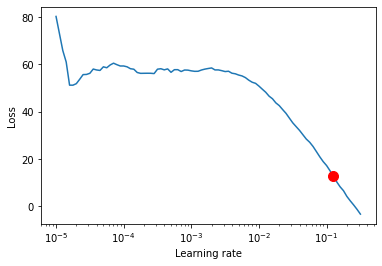

In [7]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [8]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=10,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=0.1,
    log_interval=10,
    log_val_interval=1,
    hidden_size=15,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=10),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 0     
3 | rnn                    | LSTM                               | 3.0 K 
4 | distribution_projector | Linear                             | 192   
------------------------------------------------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  97%|▉| 30/31 [00:07<00:00,  4.11it/s, loss=-13.7, v_num=318, train_los
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 31/31 [00:07<00:00,  4.13it/s, loss=-13.7, v_num=318, train_los
Epoch 1:  97%|▉| 30/31 [00:06<00:00,  4.60it/s, loss=-85.7, v_num=318, train_los
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 31/31 [00:06<00:00,  4.60it/s, loss=-85.7, v_num=318, train_los
Epoch 2:  97%|▉| 30/31 [00:07<00:00,  3.92it/s, loss=-107, v_num=318, train_loss
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 31/31 [00:07<00:00,  3.95it/s, loss=-107, v_num=318, train_loss
Epoch 3:  97%|▉| 30/31 [00:06<00:00,  4.41it/s, loss=-111, v_num=318, train_loss
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [0

In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [10]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.4364)

In [12]:
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
raw_predictions, x = net.predict(val_dataloader, mode="raw", return_x=True, n_samples=100)

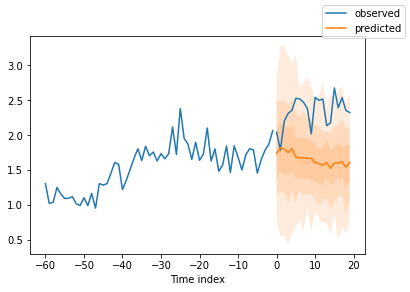

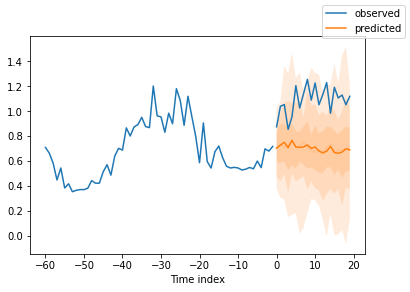

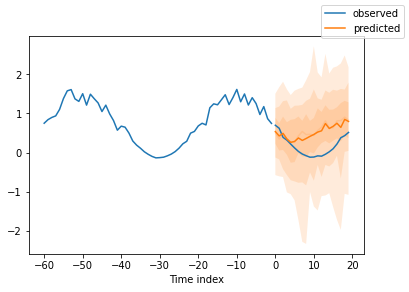

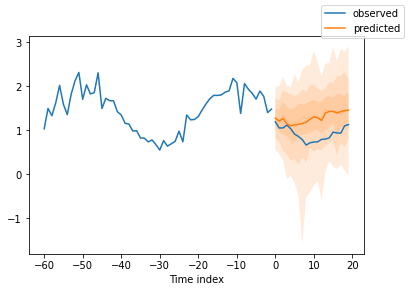

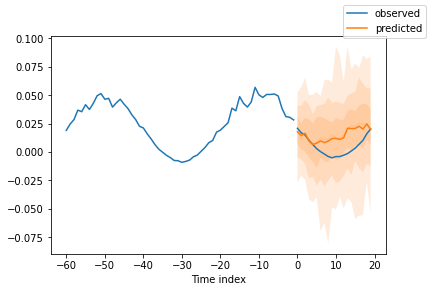

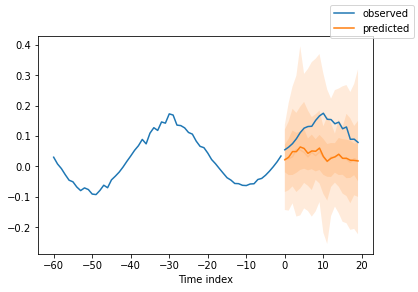

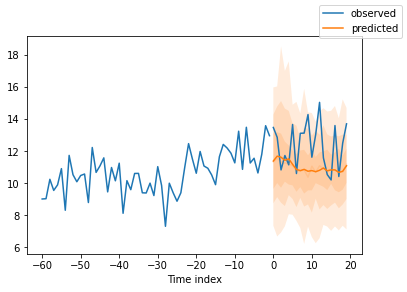

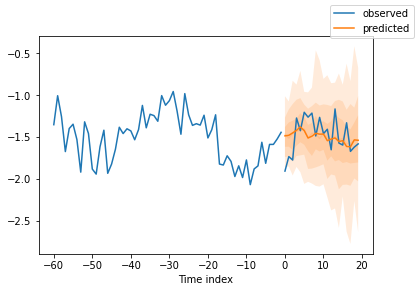

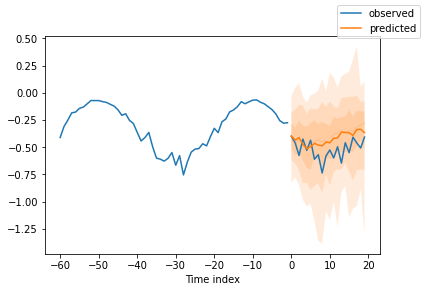

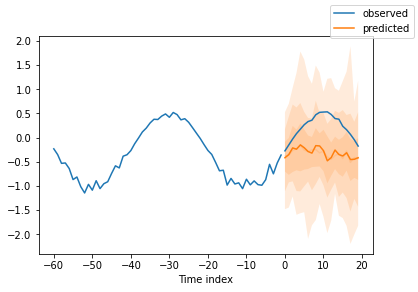

In [13]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

When using DeepVAR as a multivariate forecaster, we might be also interested in the correlation matrix.

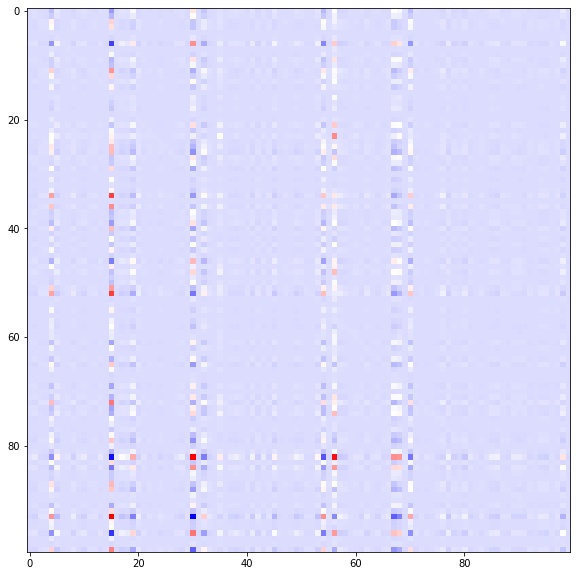

In [14]:
cov_matrix = net.loss.map_x_to_distribution(
    net.predict(val_dataloader, mode=("raw", "prediction"), n_samples=None)
).covariance_matrix.mean(0)

# normalize the covariance matrix diagnoal to 1.0
correlation_matrix = cov_matrix / torch.sqrt(torch.diag(cov_matrix) * torch.diag(cov_matrix).T)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(correlation_matrix, cmap="bwr");